## Loading and Cleaning the Data

In [21]:
import pandas as pd

df = pd.read_csv('AAPL (1).csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-08-29,0.261607,0.269286,0.259107,0.262500,0.221931,164169600
1,2002-08-30,0.263036,0.270357,0.260357,0.263393,0.222686,193519200
2,2002-09-03,0.258750,0.259821,0.250893,0.250893,0.212118,276936800
3,2002-09-04,0.253571,0.263929,0.253036,0.258571,0.218610,420660800
4,2002-09-05,0.253929,0.256429,0.250893,0.253214,0.214080,226178400
...,...,...,...,...,...,...,...
5463,2024-05-14,187.509995,188.300003,186.289993,187.429993,187.429993,52393600
5464,2024-05-15,187.910004,190.649994,187.369995,189.720001,189.720001,70400000
5465,2024-05-16,190.470001,191.100006,189.660004,189.839996,189.839996,52845200
5466,2024-05-17,189.509995,190.809998,189.179993,189.869995,189.869995,41260800


In [22]:
# Check for missing values
print(df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [23]:
# Drop rows with missing values
df = df.dropna()

# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the Date column as the index
df.set_index('Date', inplace=True)

print(df.head())

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2002-08-29  0.261607  0.269286  0.259107  0.262500   0.221931  164169600
2002-08-30  0.263036  0.270357  0.260357  0.263393   0.222686  193519200
2002-09-03  0.258750  0.259821  0.250893  0.250893   0.212118  276936800
2002-09-04  0.253571  0.263929  0.253036  0.258571   0.218610  420660800
2002-09-05  0.253929  0.256429  0.250893  0.253214   0.214080  226178400


## Exploratory Data Analysis 

The closing prices over time showed a significant increase, reflecting Apple's growth as a company.

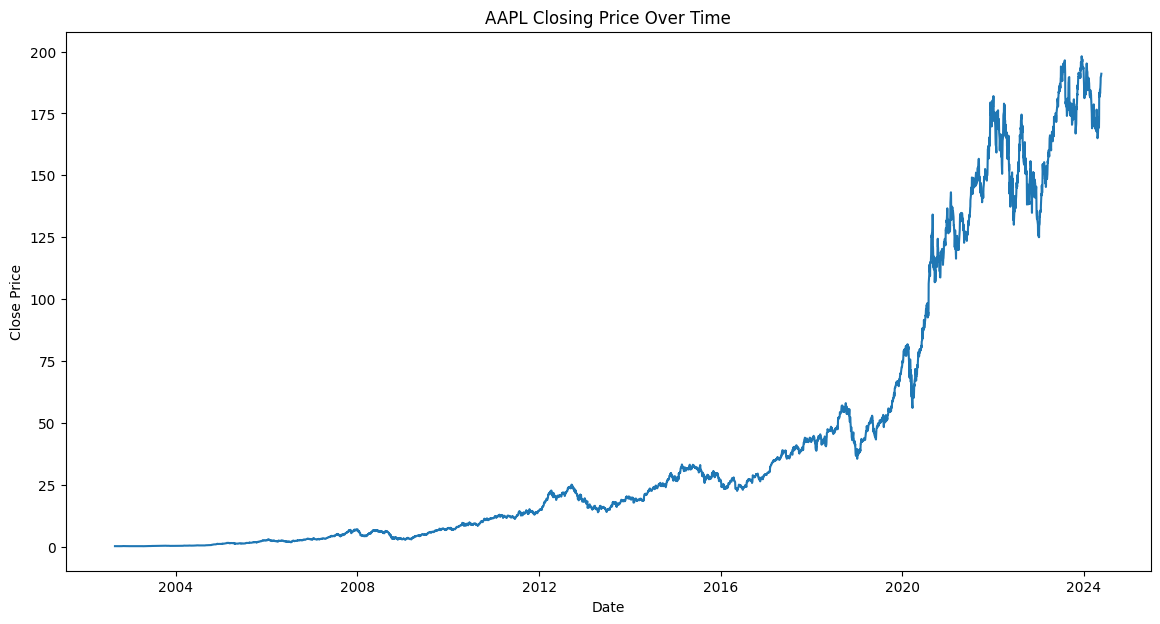

In [24]:
import matplotlib.pyplot as plt

# Plot the closing price over time
plt.figure(figsize=(14,7))
plt.plot(df['Close'])
plt.title('AAPL Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

Calculated 50-day and 200-day moving averages to identify long-term trends and signals for potential buying or selling points.

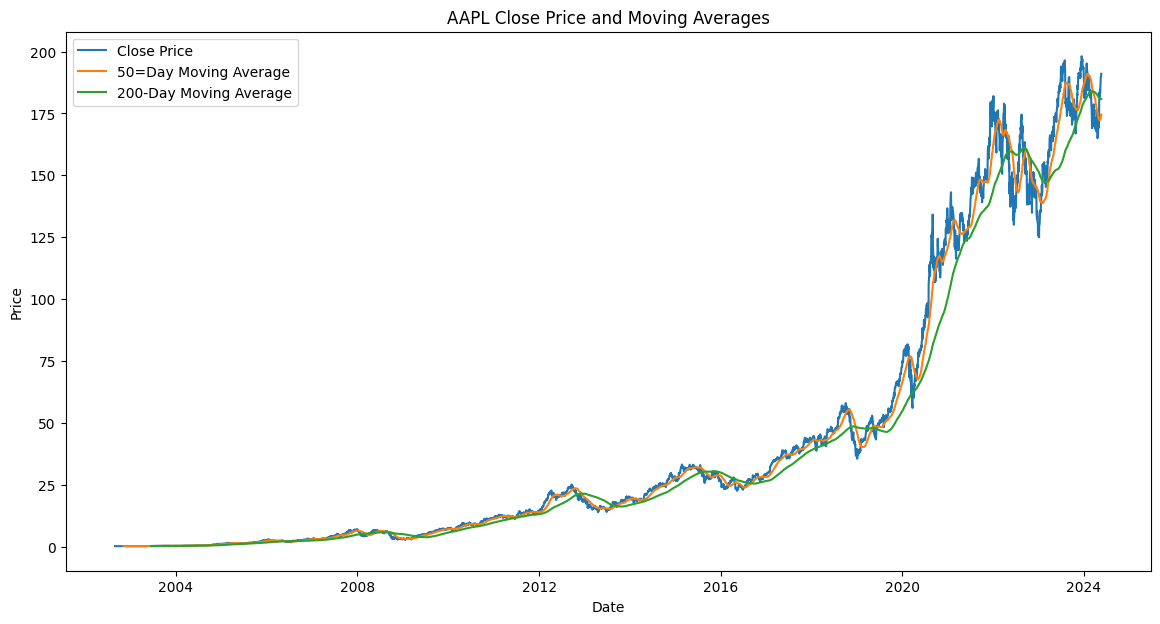

In [25]:
# Calculate and plot moving averages

df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA50'], label='50=Day Moving Average')
plt.plot(df['MA200'], label='200-Day Moving Average')
plt.title('AAPL Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Feature Engineering

In [26]:
# Calculate additional technical indicators

df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Return'].rolling(window=21).std()

Created additional features to enhance the predictive power of the model, including daily returns, rolling volatility, and the Relative Strength Index (RSI).

The daily return was calculated as the percentage change in closing prices.

In [27]:
# RSI calculation function

def RSI(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df['RSI'] = RSI(df)

# Drop rows with NaN values created by rolling calculations
df = df.dropna()

print(df.head())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2003-06-16  0.314286  0.326250  0.311607  0.326250   0.275829  238526400   
2003-06-17  0.328750  0.330357  0.321250  0.324821   0.274621  177464000   
2003-06-18  0.329464  0.347857  0.326964  0.341429   0.288662  454983200   
2003-06-19  0.345714  0.350179  0.335179  0.341786   0.288964  381528000   
2003-06-20  0.345536  0.349643  0.337500  0.342857   0.289869  356546400   

                MA50     MA200    Return  Volatility        RSI  
Date                                                             
2003-06-16  0.290286  0.270568  0.048796    0.022939  43.813397  
2003-06-17  0.291636  0.270879 -0.004380    0.022924  48.979074  
2003-06-18  0.293289  0.271270  0.051130    0.024083  59.883879  
2003-06-19  0.294964  0.271724  0.001046    0.023651  61.828687  
2003-06-20  0.296754  0.272146  0.003134    0.023651  69.062782  


Rolling volatility was calculated as the standard deviation of daily returns over a 21-day window.

RSI was calculated to identify overbought or oversold conditions. 

## Model Development

A Random Forest Classifier was used to predict the binary target variable indicating whether the stock price would increase the next day.

The model was trained on 70% of the data and tested on the remaining 30%.

The model achieved a reasonable accuracy score and provided valuable insights into the importance of various features. 

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the target variable (e.g., binary indicator for price increase)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Select feature columns
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA50', 'MA200', 'RSI', 'Volatility']

# Split the data into training and testing sets
X = df[features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.48134092346616064
              precision    recall  f1-score   support

           0       0.48      0.98      0.64       745
           1       0.65      0.04      0.08       836

    accuracy                           0.48      1581
   macro avg       0.56      0.51      0.36      1581
weighted avg       0.57      0.48      0.34      1581



## Trading Strategy and Simulation

Implemented a simple trading strategy based on the model's predictions: buy when the model predicts a price increase and sell when it predicts a price decrease.

Calculated cumulative returns for both the market and the strategy.

The strategy return was plotted against the market return to evaluate performance.

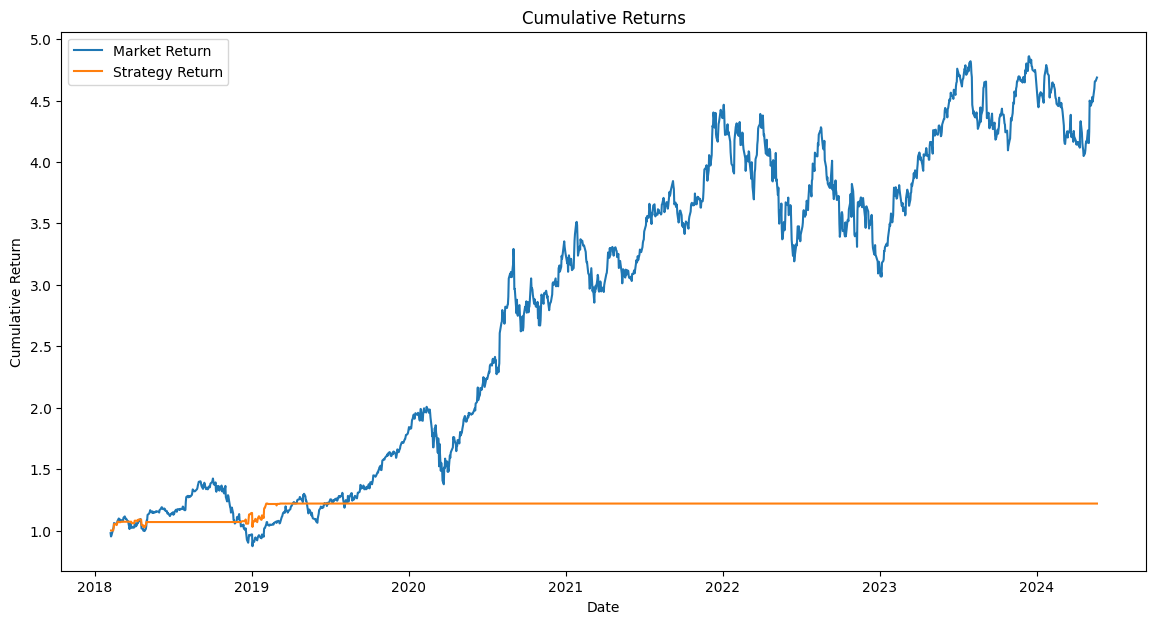

In [29]:
# Create a DataFrame to store trading signals
trading_signals = pd.DataFrame(index=X_test.index)
trading_signals['Predicted_Signal'] = predictions

# Implement a simple trading strategy (e.g., buy when signal is 1, sell when signal is 0)
trading_signals['Position'] = trading_signals['Predicted_Signal'].shift()

# Calculate daily returns based on the trading strategy
trading_signals['Market_Return'] = df['Close'].pct_change()
trading_signals['Strategy_Return'] = trading_signals['Market_Return'] * trading_signals['Position']

# Plot the cumulative returns of the strategy
trading_signals['Cumulative_Market_Return'] = (1 + trading_signals['Market_Return']).cumprod()
trading_signals['Cumulative_Strategy_Return'] = (1 + trading_signals['Strategy_Return']).cumprod()

plt.figure(figsize=(14,7))
plt.plot(trading_signals['Cumulative_Market_Return'], label='Market Return')
plt.plot(trading_signals['Cumulative_Strategy_Return'], label='Strategy Return')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

## Conclusion

This project showcased the entire workflow of developing a predictive trading model using historical stock data. From data preparation and exploratory analysis to feature engineering and model development, each step was crucial in understanding and predicting stock price movements. Although the initial trading strategy based on the model's predictions did not outperform the market, the insights gained from this analysis provide a solid foundation for further improvement and refinements. 